# Hypergraph information

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sb
from scipy import linalg

from numpy.linalg import matrix_power, multi_dot
sb.set_theme(style="ticks", context="paper")

import string
from math import factorial

In [2]:
#import simplicial_utils as su
import xgi
#import pygraphviz as pgv

## Information functions

In [3]:
def construct_hg_multilayer(G):
    """
    returns:
    1) a list of Laplacians, ordered by their order!
    2) the total Laplacian matrix
    """
    max_d = xgi.max_edge_order(G)
    hg_m = []
    for d in range(1, max_d+1):
        #K, Adj, L = su.compute_laplacians(G, d+1)
        L = xgi.laplacian(G, d, rescale_per_node=False)
        K = xgi.degree_matrix(G, d)
        Adj = xgi.adjacency_matrix(G, d)
        hg_m.append(L)
    N = G.num_nodes
    hg_all = np.zeros((N,N))
    for l in range(len(hg_m)):
        hg_all = hg_all + hg_m[l]
    return hg_m, hg_all

def density(Lap,tau):  
    """
    Returns the density matrix for Laplacian
    """
    rho = linalg.expm(-2 * tau * Lap)
    rho = rho/np.trace(rho) + np.eye(len(rho))*10**-15
    return rho

def partition(Lap,tau):   
    """
    Returns the partition function
    """
    return np.trace(linalg.expm(-2 * tau * Lap))

def KL(rho_emp,rho_model):    
    """
    Returns the KL divergence between empirical observation and model
    """
    return np.trace(  np.matmul(rho_emp, linalg.logm(rho_emp)) - np.matmul(rho_emp, linalg.logm(rho_model)))   

def optimization(G,tau):  
    """
    returns the gain and loss for modeling the whole hypergraph (up to order d_max),
    using a part of it, up to order d < d_max.
    """
    hg_m, hg_all = construct_hg_multilayer(G)
    rho_all = density(hg_all,tau)
    print(len(rho_all))
    
    D = []
    lZ = []
    N = G.num_nodes
    L_l = np.zeros((N,N))
    for l in range(len(hg_m)):
        L_l = L_l + hg_m[l]
        rho_l = density(L_l,tau)
        Z_l   = partition(L_l,tau)

        D.append(KL(rho_all,rho_l)) 
        lZ.append(np.log(Z_l))

    lZ = np.array(lZ)   ### Penalization term for model complexity
    D = np.array(D)     ### Learning error
    
    return D, lZ

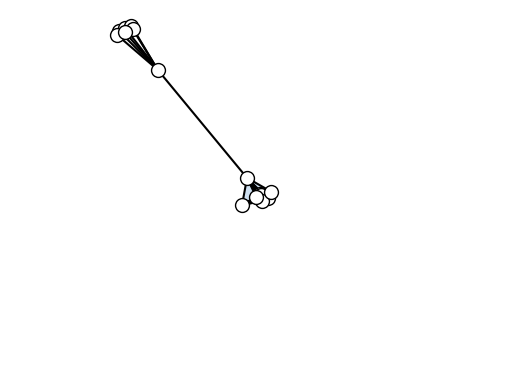

In [4]:
m = 7
k = 10
d_max = 9
G = xgi.star_clique(m, k, d_max=d_max)

# Uncomment to generate other types of hypergraphs
# Other options can be found here https://xgi.readthedocs.io/en/latest/api/generators.html
# And datasets with e.g. H_enron = xgi.load_xgi_data("email-enron")

N = 50 # number of nodes
ps=[0.05, 0.001, 0.0001, 0.00001] # wiring probabilities at each order

#G = xgi.random_hypergraph(50, ps=[0.05, 0.001, 0.0001, 0.00001])
#G = xgi.random_simplicial_complex(N=N, ps=ps)

xgi.draw(G)

In [5]:
tau = 1                                    ### Tune the propagation scale in the system
hg_m, hg_all = construct_hg_multilayer(G)  ### Makes a list of Laplacians of orders
D, lZ = optimization(G,tau)                ### Returns gain and loss 

17


In [19]:
def plot_information(H, taus):

    fig, axs = plt.subplots(
        1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
    )

    d_max = xgi.max_edge_order(H)
    orders = range(1, d_max + 1)

    for i, tau in enumerate(taus):

        D, lZ = optimization(H, tau)

        axs[i].plot(orders, lZ - D, "o-")

        axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
        axs[i].set_xlabel("Max order")
        axs[i].set_xticks(orders)

    axs[0].set_ylabel("Quality function")

    sb.despine()
    
    return fig

## Quality function at three different propagation scales

### starclique

In [56]:
m = 7
k = 20
d_max = 9
G = xgi.star_clique(m, k, d_max=d_max)

27
27
27


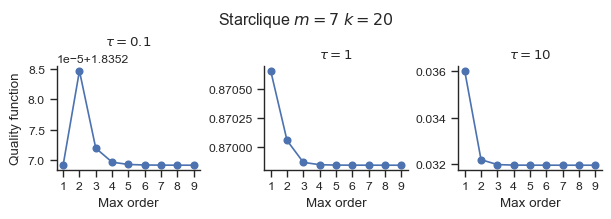

In [57]:
taus = [0.1, 1, 10]

fig = plot_information(G, taus)
plt.suptitle(f"Starclique $m={m}$ $k={k}$")

fig_name = f"starclique_m_{m}_k_{k}"
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

### random simplicial complex

In [51]:
N = 50 # number of nodes
ps=[0.05, 0.001, 0.0001, 0.00001] # wiring probabilities at each order

#H = xgi.random_hypergraph(50, ps=ps)
S = xgi.random_simplicial_complex(N=N, ps=ps)

50
50
50


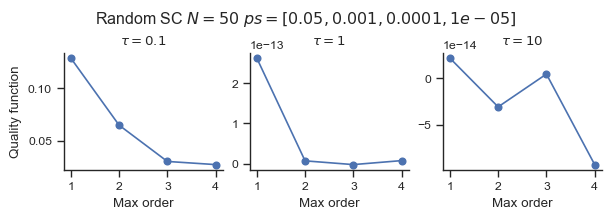

In [52]:
taus = [0.1, 1, 10]

fig = plot_information(S, taus)
plt.suptitle(f"Random SC $N={N}$ $ps={ps}$")

fig_name = f"random_SC_N_{N}_ps_{ps}"
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

### random hypergraph

In [58]:
N = 50  # number of nodes
ps = [0.05, 0.001, 0.0001, 0.00001]  # wiring probabilities at each order

H = xgi.random_hypergraph(N, ps=ps)

50
50
50


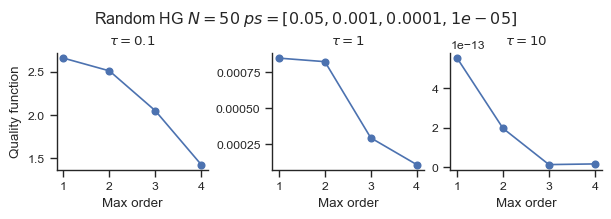

In [59]:
taus = [0.1, 1, 10]

fig = plot_information(H, taus)
plt.suptitle(f"Random HG $N={N}$ $ps={ps}$")

fig_name = f"random_HG_N_{N}_ps_{ps}"
plt.savefig(f"{fig_name}.png", dpi=250, bbox_inches="tight")

plt.show()

### multiple realisations

In [ ]:
n_rep = 5

N = 50  # number of nodes
ps = [0.05, 0.001, 0.0001, 0.00001]  # wiring probabilities at each order

SCs = []

fig, axs = plt.subplots(
    1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
)

for j in range(n_rep):
    
    S = xgi.random_simplicial_complex(N=N, ps=ps)

    d_max = xgi.max_edge_order()
    orders = range(1, d_max + 1)

    for i, tau in enumerate(taus):

        D, lZ = optimization(H, tau)

In [108]:
S = xgi.SimplicialComplex([["x"], [2,3], [2,3,4]])

In [109]:
S.nodes

NodeView(('x', 2, 3, 4))

In [110]:
S.edges

EdgeView((0, 1, 2, 3, 4))

In [67]:
S.edges.members()

[frozenset({'x'}),
 frozenset({2, 3}),
 frozenset({2, 3, 4}),
 frozenset({2, 4}),
 frozenset({3, 4})]

In [88]:
S.edges.filterby("size", 2, mode="geq")

EdgeView((1, 2, 3, 4))

In [89]:
S.edges.filterby("size", 2, mode="geq").members()

[frozenset({2, 3}), frozenset({2, 3, 4}), frozenset({2, 4}), frozenset({3, 4})]

In [90]:
orientations = [0, 1, 0, 1]

In [93]:
S1 = xgi.SimplicialComplex()
S1.add_simplex([1,2])
S1.edges

EdgeView((0,))

In [94]:
S1.edges.members()

[frozenset({1, 2})]

In [97]:
S1.remove_simplex_id(0)

In [100]:
S1.edges.members()

[]

In [101]:
S1.add_simplex([2,3])
S1.edges

EdgeView((1,))

In [102]:
orientations

[0, 1, 0, 1]

In [105]:
di = {idd: orientations[i] for i, idd in enumerate(list(S.edges.filterby("order", 1, mode="geq"))) }

In [106]:
di

{1: 0, 2: 1, 3: 0, 4: 1}

In [118]:
S.edges.filterby("order", )

EdgeView((2,))

In [ ]:
xgi.convert_labels_to_integers()

In [61]:
isinstance(3, list)

False

In [ ]:
if not isinstance(S, xgi.SimplicialComplex): 
    raise XGIerror("")